# Predicting Player Transfer Value

**By:** Inesh Jacob, Vedangi Patel, Nate Piplias, and Rodrigo Tiscareno

**Note:** The cells are designed and implemented to be run in-sequence. There may be dependencies on previously-run cells. This applies for cells subsequent to the reading of the 'player_dataset.csv'

## Table of Contents
* [Introduction](#introduction)
* [Data Extraction](#data-extraction)
* [Data Transformations](#data-transformations)
* [Feature Refinement](#data-refinement)
* [Data Exploration](#data-exploration)
* [Player Play Style - Clustering Algorithm](#clustering)
* [Predicting Player Play Style by Linear Regression](#linear-regression)



## Introduction <a class="anchor" id="introduction"></a>

To this day, there are more than 128,983 professional football players registered within FIFA’s system. With tight transfer budgets and growing competition from fierce rivals and clubs around the world, teams need to be fiscally responsible with who they acquire and for what value. Even the largest clubs in the world with budgets eclipsing £100 million risk falling into financial difficulty if they are unable to control their spending on players. Many teams take huge gambles on players, leveraging debt and key assets to try and win championships.  

An excellent example of this would be Chelsea FC who has spent two billion euros on transfers in the past 5 years with €660 million financed using debt with more than 82% of that incurred this year. With every season that passes by it seems that more and more money is being spent on transfers and player contracts. 

By approaching and evaluating player transfer fees from a performance-metric perspective, player transfer values can be predicted as close to a player’s actual playing performance as closely as possible. 

Through analysis of player data from previous seasons and their listed transfer values, a model can be created to accurately predict a player’s value regardless of what team or league they are currently a part of. As a result, teams with only a couple thousand available to spend as well as those with tens of millions of dollars at their disposal will be better equipped to make smart decisions to improve their team while still remaining profitable. 

In this analysis, we perform multi-variable linear regression to calculate and predict a player's transfer value based on their personal information and their in-game statistics from thr 2022-2023 season.


## Data Extraction <a class="anchor" id="data-extraction"></a>

**Note**: The data extraction process can take up to 10 minutes (data web-scraping and aggregation). Please run the cells in order to produce the best results. If you'd like access to the final player dataset after the data extraction, please click here.

In [3]:
import pandas as pd
import numpy as np
import os
import requests
from bs4 import BeautifulSoup
from functools import reduce
from unidecode import unidecode
import re
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

Please download config.py from this directory. It will contain a Python script with all configuration information necessary to perform the webscraping and data extraction for this project.

In [2]:
from config import STAT_LINKS, DF_ORDER, INFO_LINKS, NATIONS

In [3]:
def get_player_statistics(stat_links, df_order):
    for nations in STAT_LINKS:
        for team in STAT_LINKS[nations]:
            df_list = pd.read_html(STAT_LINKS[nations][team], header=1)
            for i, df in enumerate(df_list):
                if not os.path.isdir(f"{nations}/player_stats/{team}/"):
                    os.makedirs(f"{nations}/player_stats/{team}/")
                df.to_csv(f"{nations}/player_stats/{team}/{df_order[i]}.csv", index=False)

In [4]:
get_player_statistics(STAT_LINKS, DF_ORDER)

In [5]:
def get_player_info(INFO_LINKS):
    
    for nation in INFO_LINKS:
        for team in INFO_LINKS[nation]:

        # Get team name.
            team_name = team.split("/")[3]

            headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}
            page = team
            pageTree = requests.get(page, headers=headers)
            pageSoup = BeautifulSoup(pageTree.content, 'html.parser')

            # Acquire player names, prices and positions. 
            names = []
            positions = []
            tables= pageSoup.find_all('table', class_='inline-table')
            for table in tables:
                rows = table.find_all('tr')
                name = rows[0].text.strip()
                position = rows[1].text.strip()
                names.append(name)
                positions.append(position)

            player_prices = pageSoup.find_all(class_='rechts hauptlink')
            prices = []
            for price in player_prices:
                price = price.text.strip()
                prices.append(price)

            # Store in info dataframe.
            info = pd.DataFrame({'name': names, 'price': prices, 'position':positions})

            # Custom logic to acquire dob, nationality, height, foot, join_date, and contract_expiration.
            data_rows = []
            tables= pageSoup.find_all('table', class_='items')
            for table in tables:
                rows = table.find_all('td', {"class": "zentriert"})
                for i in range(len(rows)):
                    data_rows.append(rows[i])


            general = [data_rows[i:i + 8] for i in range(0, len(data_rows), 8)]
            overall = []
            for g in general:
                overall.append(dict(
                  dob = g[1].text.strip(),
                  nationality = g[2].img['alt'],
                  height = g[3].text.strip(),
                  foot = g[4].text.strip(),
                  join_date = g[5].text.strip(),
                  contract_expiration = g[7].text.strip(), 
              )
              )
            # Create info2 dataframe with additional information.
            info2 = pd.DataFrame(overall)

            # Concat info with info2 to combine information.
            overall = pd.concat([info, info2], axis=1)

            if not os.path.isdir(f"{nation}/player_info"):
                  os.makedirs(f"{nation}/player_info")

            # Export dataframe to nation directory.
            overall.to_csv(f"{nation}/player_info/{team_name}.csv", index=False)

In [6]:
get_player_info(INFO_LINKS)

In [9]:
def clean_up_defensive_actions(df):
    df = df.iloc[:-2]
    
    df.drop(columns=[
        '90s',
        'Matches',
        'Nation',
        'Pos',
        'Age',
        'Tkl.1',
        'Att',
        'Tkl%',
        'Lost',
        'Blocks',
        'Tkl+Int',
        'Pass'
    ], inplace=True)
    
    df.rename(columns={
        'Tkl': 'tackles',
        'TklW': 'tackles_won',
        'Def 3rd': 'defensive_third_tackles',
        'Mid 3rd': 'midfield_tackles',
        'Att 3rd': 'attacking_third_tackles',
        'Sh': 'shots_blocked',
        'Pass': 'passes_blocked',
        'Int': 'interceptions',
        'Clr': 'clearances',
        'Err': 'errors_leading_to_goal'
    }, inplace=True)
    
    return df

In [10]:
def clean_up_goal_and_shot(df):
    df = df.iloc[:-2]
    
    df.drop(columns=[
        '90s',
        'Matches',
        'Nation',
        'Pos',
        'Age',
        'SCA90',
        'GCA90',
    ], inplace=True)
    
    df.rename(columns={
        'SCA': 'shot_creating_actions',
        'PassLive': 'sca_live_passes',
        'PassDead': 'sca_dead_passes',
        'TO': 'sca_take_ons',
        'Sh': 'sca_shots',
        'Fld': 'sca_fouls_drawn',
        'Def': 'sca_defensive_actions',
        'GCA': 'goal_creation_actions',
        'PassLive.1': 'gca_live_passes',
        'PassDead.1': 'gca_dead_passes',
        'TO.1': 'gca_take_ons',
        'Sh.1': 'gca_shots',
        'Fld.1': 'gca_fouls_drawn',
        'Def.1': 'gca_defensive_actions',
    }, inplace=True)
    
    return df

In [11]:
def clean_up_miscellaneous(df):
    df = df.iloc[:-2]
    
    df.drop(columns=[
        '90s',
        'Matches',
        'Nation',
        'Pos',
        'Age',
        '2CrdY',
        'Crs',
        'Int',
        'TklW',
        'Won%',
    ], inplace=True)
    
    df.rename(columns={
        'CrdY': 'yellow_cards',
        'CrdR': 'red_cards',
        'Fls': 'fouls',
        'Fld': 'fouls_drawn',
        'Off': 'offsides',
        'Fls': 'fouls',
        'Fld': 'fouls_drawn',
        'Off': 'offsides',
        'PKwon': 'penalties_won',
        'PKcon': 'penalties_conceded',
        'OG': 'own_goals',
        'Recov': 'ball_recoveries',
        'Won': 'aerial_duels_won',
        'Lost': 'aerial_duels_lost',
    }, inplace=True)
    
    return df

In [12]:
def clean_up_passing(df):
    df = df.iloc[:-2]
    
    df.rename(columns={
        'Cmp.1': 'short_passes_completed',
        'Att.1': 'short_passes_attempted',
        'Cmp.2': 'medium_passes_completed',
        'Att.2': 'medium_passes_attempted',
        'Cmp.3': 'long_passes_completed',
        'Att.3': 'long_passes_attempted',
        'Ast': 'assists',
        'xA': 'expected_assists',
        'KP': 'key_passes',
        '1/3': 'passes_into_final_third',
        'PPA': 'passes_into_penalty_box',
        'CrsPA': 'crosses_into_penalty_area',
        'PrgP': 'progressive_passes',
    }, inplace=True)
   
    df.drop(columns=[
        '90s',
        'Matches',
        'Nation',
        'Pos',
        'Age',
        'Cmp',
        'Att',
        'Cmp%',
        'TotDist',
        'PrgDist',
        'Cmp%.1',
        'Cmp%.2',
        'Cmp%.3',
        'xAG',
        'A-xAG',
    ], inplace=True)
    
    return df

In [13]:
def clean_up_playing_time(df):
    df = df.iloc[:-2]
    
    df = df[['Player', 'Min', 'MP', 'Starts']]
    
    df.rename(columns={
        'Min': 'minutes_played',
        'MP': 'matches_played',
        'Starts': 'matches_started',
    }, inplace=True)
    
    return df

In [14]:
def clean_up_possession(df):
    df = df.iloc[:-2]
    
    df.drop(columns=[
        '90s',
        'Matches',
        'Nation',
        'Pos',
        'Age',
        'Touches',
        'Live',
        'Succ%',
        'Tkld%',
        'Rec',
        'PrgR',
    ], inplace=True)
    
    df.rename(columns={
        'Def Pen': 'touches_penalty_area_defending',
        'Def 3rd': 'touches_defensive_third',
        'Mid 3rd': 'touches_middle_third',
        'Att 3rd': 'touches_attacking_third',
        'Att Pen': 'touches_penalty_area_attacking',
        'Att': 'attempted_take_ons',
        'Succ': 'successful_take_ons',
        'Tkld': 'tackled_take_ons',
        'Carries': 'carries',
        'TotDist': 'total_carrying_distance',
        'PrgDist': 'progressive_carrying_distance',
        'PrgC': 'progressive_carries',
        '1/3': 'carries_into_final_third',
        'CPA': 'carries_into_penalty_area',
        'Mis': 'carry_miscontrols',
        'Dis': 'carry_dispossessions',
    }, inplace=True)
    
    return df

In [15]:
def clean_up_shooting(df):
    df = df.iloc[:-2]
    
    df.drop(columns=[
        '90s',
        'Matches',
        'Nation',
        'Pos',
        'Age',
        'SoT%',
        'Sh/90',
        'SoT/90',
        'G/SoT',
        'npxG',
        'npxG/Sh',
        'G-xG',
        'np:G-xG',
    ], inplace=True)
    
    df.rename(columns={
        'Gls': 'goals',
        'Sh': 'total_shots',
        'SoT': 'shots_on_target',
        'G/Sh': 'goals_per_shot',
        'Dist': 'average_shot_distance',
        'FK': 'freekick_shots',
        'PK': 'penalty_kicks_converted',
        'PKatt': 'penalty_kicks_attempted',
    }, inplace=True)
    
    return df

In [29]:
# Perform the general dropping and renaming of columns.
def clean_up_statistic_dataframes(directory):
    
    files = [
        ("playing_time.csv", clean_up_playing_time),
        ("defensive_actions.csv", clean_up_defensive_actions),
        ("goal_and_shot_creation.csv", clean_up_goal_and_shot),
        ("miscellaneous_tasks.csv", clean_up_miscellaneous),
        ("passing.csv", clean_up_passing),
        ("possession.csv", clean_up_possession),
        ("shooting.csv", clean_up_shooting),
    ]
    
    dfs = []
    for file, clean_func in files:
        df = pd.read_csv(f"{directory}/{file}")
        df = clean_func(df)
        dfs.append(df)
    
    df_merged = pd.concat(dfs, axis=1)
    
    return df_merged


In [26]:
# For each nation, compile the in-game statistics dataset.
def get_statistics_df(NATIONS):
    for nation in NATIONS:
        rootdir = f'{nation}/player_stats/'
        dfs = []
        for i, file in enumerate(os.listdir(rootdir)):
            d = os.path.join(rootdir, file)
            if ".ipynb_checkpoints" in d:
                continue
            dfs.append(clean_up_statistic_dataframes(d))
        result_df = pd.concat(dfs, ignore_index=True)
        result_df = result_df.loc[:, ~result_df.columns.duplicated()]

        result_df.to_csv(f"{nation}/overall_player_stats.csv", index=False)

In [ ]:
get_statistics_df(NATIONS)

In [27]:
# For each nation, compile the player information dataset.
def get_information_df(NATIONS):
    for nation in NATIONS:
        directory = f'{nation}/player_info'

        csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

        dfs = []

        for csv_file in csv_files:
            df = pd.read_csv(os.path.join(directory, csv_file))
            dfs.append(df)

        merged_df = pd.concat(dfs, ignore_index=True)

        merged_df.to_csv(f"{nation}/player_info.csv", index=False)

In [21]:
get_information_df(NATIONS)

In [28]:
# Join the player information and player statistics tables for each nation.
def compile_nation_df(NATIONS):
    for nation in NATIONS:

        df1 = pd.read_csv(f"{nation}/player_info.csv")
        df2 = pd.read_csv(f"{nation}/overall_player_stats.csv")

        df1["normalized_named"] = df1["name"].apply(unidecode)
        df2["normalized_named"] = df2["Player"].apply(unidecode)

        merged_df = pd.merge(df1, df2, on="normalized_named", how="inner")
        merged_df.drop(columns=["normalized_named", "Player"], axis=1, inplace=True)
        
        if not os.path.isdir(f"finalized_nation_datasets"):
                  os.makedirs(f"finalized_nation_datasets")
        
        merged_df.to_csv(f"finalized_nation_datasets/{nation}_dataset.csv", index=False)

In [23]:
compile_nation_df(NATIONS)

In [30]:
# For each nation's combined dataset, compile and aggregate the data to produce the overall player_dataset.csv file.
def get_general_dataset():
    directory = f'finalized_nation_datasets/'

    csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

    dfs = []

    for csv_file in csv_files:
        df = pd.read_csv(os.path.join(directory, csv_file))
        dfs.append(df)

    merged_df = pd.concat(dfs, ignore_index=True)

    merged_df.to_csv(f"player_dataset.csv", index=False)

In [31]:
get_general_dataset()

## Data Transformation <a class="anchor" id="data-transformations"></a>

#### Converting Price Variable to a Numerical Variable

In [41]:
df = pd.read_csv('player_dataset.csv')

In [42]:
df['price'] = df['price'].str.replace('.', '')
df['price'] = df['price'].str.replace('€', '')
df['price'] = df['price'].str.replace('m', '0000').str.replace('k', '000')
df['price'] = df['price'].astype('double', errors='ignore')
df = df[df['price'] != '-'].reset_index(drop=True)
df['price'] = df['price'].astype('int')

/var/folders/tf/28wdj00j4h1_5_yq0wc9jwm40000gn/T/ipykernel_45389/3585879976.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['price'] = df['price'].str.replace('.', '')


In [43]:
df['price'].head()

0    1200000
1     500000
2     400000
3    5000000
4    3500000
Name: price, dtype: int64

#### Deleting Goalkeepers or Players With No Playing Time

In [44]:
df = df[~df['minutes_played'].isna()].reset_index(drop=True)
df = df[df['position'] != 'Goalkeeper'].reset_index(drop=True)

In [45]:
df[df['minutes_played'].isna()]

,name,price,position,dob,nationality,height,foot,join_date,contract_expiration,minutes_played,...,carry_dispossessions,goals,total_shots,shots_on_target,goals_per_shot,average_shot_distance,freekick_shots,penalty_kicks_converted,penalty_kicks_attempted,xG


In [46]:
df[df['position'] == 'Goalkeeper']

,name,price,position,dob,nationality,height,foot,join_date,contract_expiration,minutes_played,...,carry_dispossessions,goals,total_shots,shots_on_target,goals_per_shot,average_shot_distance,freekick_shots,penalty_kicks_converted,penalty_kicks_attempted,xG


#### Mapping Poisitions to General Positions

In [47]:
position_mappings = {'Centre-Back': 'Defender', 'Left-Back': 'Defender', 'Right-Back': 'Defender',
                  'Attacking Midfield': 'Midfielder', 'Central Midfield': 'Midfielder', 'Central Midfielder': 'Midfielder', 'Defensive Midfield': 'Midfielder', 'Left Midfield': 'Midfielder', 'Right Midfield': 'Midfielder',
                  'Left Winger': 'Attacker', 'Right Winger': 'Attacker', 'Centre-Forward': 'Attacker', 'Second Striker': 'Attacker'}

# Map positions to roles using the position_roles dictionary
df['position'] = df['position'].map(position_mappings)


In [48]:
df['position'].value_counts()

Defender      1069
Midfielder     894
Attacker       837
Name: position, dtype: int64

#### Extracting Age from Date of Birth

In [49]:
def extract_age(date_str):
    return int(re.search(r'\((\d+)\)', date_str).group(1))

In [50]:
df['dob'] = df['dob'].apply(extract_age)

In [51]:
df = df.rename(columns={'dob':'age'})

In [52]:
df['age'].head()

0    24
1    30
2    25
3    25
4    29
Name: age, dtype: int64

#### Date Conversions

In [53]:
def date_conversion(x):
    if x == '-':
        return
    else:
        return datetime.strptime(x, '%b %d, %Y')

In [54]:
df['join_date'] = df['join_date'].apply(date_conversion)
df['contract_expiration'] = df['contract_expiration'].apply(date_conversion)

#### Converting Height to Numerical Variable

In [55]:
def transform_height(height):
    if height == '-':
        return
    else:
        height_m = float(height.replace(',', '.')[:-1])
        height_cm = height_m * 100
        return height_cm

In [56]:
df['height'] = df['height'].apply(transform_height)

#### One-Hot-Encoding Position & Preferred Foot

In [57]:
one_hot = pd.get_dummies(df['position'])
df = pd.concat([df, one_hot], axis=1)

In [58]:
one_hot = pd.get_dummies(df['foot'])
df = pd.concat([df, one_hot], axis=1)

## Feature Refinement <a class="anchor" id="data-refinement"></a>

Many of our variables can be simplified, reduced, or eliminated from the dataframe. Our team determined which variables were reducible, negligible, or not contributing to player price and we made the following feature refinement decisions.

### Summary of Features Dropped

1. [Passes](#passes)
2. [Tackles](#tackles)
3. [Shot-Creating Actions](#sca)
4. [Goal-Creating Actions](#gca)
5. [Defensive Actions](#defensive-actions)
6. [Assists](#assists)
7. [Take-ons](#take-ons)
8. [Carries](#carries)
9. [Progressive Passes](#progressive-passes)
10. [Touches](#touches)
11. [Goals](#goals)
12. [Shots](#shots)
13. [Cards](#cards)
14. [Aerial Duels](#aerial-duels)
15. [Miscellaneous](#misc)


#### Passes <a class="anchor" id="passes"></a>

Features dropped:
    
- short_passes_attempted
- short_passes_completed
- medium_passes_attempted
- medium_passes_completed
- long_passes_attempted
- long_passes_completed

Converted to *passes* a summation of the passes completed by a player.

In [59]:
df['passes'] = df['short_passes_completed'] + df['medium_passes_completed'] +  \
+ df['long_passes_completed']

In [60]:
df.drop([
    'short_passes_completed',
    'medium_passes_completed',
    'long_passes_completed',
    'short_passes_attempted',
    'medium_passes_attempted',
    'long_passes_attempted',
    ], axis=1, inplace=True)

#### Tackles <a class="anchor" id="tackles"></a>

Features dropped:
    
- defensive_third_tackles
- midfield_tackles
- attacking_third_tackles
- tackles

The feature *tackles_won* will represent the tackling component as the main feature for a player's tackling performance.

In [61]:
df.drop(['defensive_third_tackles', 'midfield_tackles', 'attacking_third_tackles', 'tackles'], axis=1, inplace=True)

#### Shot-Creating Actions <a class="anchor" id="sca"></a>

Features dropped:
    
- sca_live_passes
- sca_dead_passes
- sca_take-ons
- sca_shots
- sca_fouls_drawn
- sca_defensive_actions
- shot_creating_actions

The feature *shot_creating_actions* is the summation of all the features specified.

In [62]:
df.drop([
    'sca_live_passes',
    'sca_dead_passes',
    'sca_take_ons',
    'sca_fouls_drawn',
    'sca_defensive_actions',
    'sca_shots',
    ], axis=1, inplace=True)

#### Goal-Creating Actions <a class="anchor" id="gca"></a>

Features dropped:
    
- gca_live_passes
- gca_dead_passes
- gca_take-ons
- gca_shots
- gca_fouls_drawn
- gca_defensive_actions


The feature *goal_creation_actions* is the summation of all the features specified.

In [63]:
df.drop([
    'gca_live_passes',
    'gca_dead_passes',
    'gca_take_ons',
    'gca_fouls_drawn',
    'gca_defensive_actions',
    'gca_shots',
    ], axis=1, inplace=True)

#### Defensive Actions <a class="anchor" id="defensive-actions"></a>

Features dropped:
    
- interceptions
- clearances
- shots_blocked
- ball_recoveries

Summed and converted to a 'defensive_actions' feature.

In [64]:
df['defensive_actions'] = df['interceptions'] + df['clearances'] + df['shots_blocked'] + df['ball_recoveries']

In [65]:
df.drop(['interceptions', 'clearances', 'shots_blocked', 'ball_recoveries'], axis=1, inplace=True)

#### Assists <a class="anchor" id="assists"></a>

Features dropped:

- expected_assists

The feature to represent assists will be the *assists*. 

In [66]:
df.drop([
    'expected_assists',
    ], axis=1, inplace=True)

#### Take-ons <a class="anchor" id="take-ons"></a>

Features dropped:
    
- attempted_take_ons
- tackled_take_ons

The feature to represent progressive passes of any type will be *successful_take_ons.*

In [67]:
df.drop([
    'attempted_take_ons',
    'tackled_take_ons',
    ], axis=1, inplace=True)

#### Carries <a class="anchor" id="carries"></a>

Features dropped:
    
- carries
- total_carrying_distance
- progressive_carrying_distance
- progressive_carries
- carries_into_final_third
- carry_miscontrols
- carry_dispossessions
- carries_into_penalty_area

The feature to represent carries of any type will be the *total_carrying_distance.*

In [68]:
df.drop([
    'carries',
    'progressive_carrying_distance',
    'progressive_carries',
    'carries_into_final_third',
    'carry_miscontrols',
    'carry_dispossessions',
    'carries_into_penalty_area',
    ], axis=1, inplace=True)

#### Progressive Passes <a class="anchor" id="progressive-passes"></a>

Features dropped:
    
- key_passes
- passes_into_final_third
- passes_into_penalty_box
- crosses_into_penalty_area
- progressive_passes

The feature to represent progressive passes of any type will be *progressive_passes.*

In [69]:
df.drop([
    'key_passes',
    'passes_into_final_third',
    'passes_into_penalty_box',
    'crosses_into_penalty_area',
    ], axis=1, inplace=True)

#### Touches <a class="anchor" id="touches"></a>

Features dropped:
    
- touches_penalty_area_defending
- touches_defensive_third
- touches_middle_third
- touches_attacking_third
- touches_penalty_area_attacking

Converted to *touches* a summation of any touches completed by a player.

In [70]:
df['touches'] = df['touches_penalty_area_defending'] +  \
df['touches_defensive_third'] + df['touches_middle_third'] + df['touches_attacking_third'] + \
df['touches_penalty_area_attacking']

In [71]:
df.drop([
    'touches_penalty_area_defending',
    'touches_defensive_third',
    'touches_middle_third',
    'touches_attacking_third',
    'touches_penalty_area_attacking',
    ], axis=1, inplace=True)

#### Goals <a class="anchor" id="goals"></a>

Features dropped:
    
- xG
- goals_per_shot

The feature to represent the *goal* metric be the *goals* feature.

In [72]:
df.drop([
    'xG',
    'goals_per_shot',
    ], axis=1, inplace=True)

#### Shots <a class="anchor" id="shots"></a>

Features dropped:
    
- shots_on_target
- average_shot_distance
- freekick_shots

The feature to represent shots of any type will be the *total_shots* feature.

In [73]:
df.drop([
    'shots_on_target',
    'average_shot_distance',
    'freekick_shots',
    ], axis=1, inplace=True)

#### Cards <a class="anchor" id="cards"></a>

Features dropped:
    
- yellow_cards
- red_cards

Converted into *cards*, a feature summing both types of cards where red cards are equivalent to **two** cards.

In [74]:
df['cards'] = df['yellow_cards'] + (2 * df['red_cards'])

In [75]:
df.drop([
    'yellow_cards',
    'red_cards'
    ], axis=1, inplace=True)

#### Aerial Duels <a class="anchor" id="aerial-duels"></a>

Features dropped:
    
- aerial_duels_lost

The feature to represent aerial duels will be the *aerial_duels_won*. 

In [76]:
df.drop(['aerial_duels_lost'], axis=1, inplace=True)

#### Miscellaneous <a class="anchor" id="misc"></a>

Features dropped:
    
- errors_leading_to_goal
- offsides
- penalties_won
- penalties_conceded
- fouls_drawn
- penalty_kicks_converted
- penalty_kicks_attempted

There are questions over the impact that these features will have in our regression model on player price.

In [77]:
df.drop([
    'errors_leading_to_goal',
    'offsides',
    'penalties_won', 
    'penalties_conceded',
    'fouls_drawn',
    'own_goals',
    'penalty_kicks_converted',
    'penalty_kicks_attempted',
    ], axis=1, inplace=True)

## Data Exploration <a class="anchor" id="data-exploration"></a>

In [78]:
df.head()

,name,price,position,age,nationality,height,foot,join_date,contract_expiration,minutes_played,...,Attacker,Defender,Midfielder,both,left,right,passes,defensive_actions,touches,cards
0,Erhan Masovic,5000000,Defender,24,Serbia,189.0,both,2020-10-05,2025-06-30,1489.0,...,0,1,0,1,0,0,453.0,182.0,864.0,2.0
1,Ivan Ordets,3500000,Defender,30,Ukraine,195.0,right,2022-07-10,2023-06-30,1729.0,...,0,1,0,0,0,1,482.0,240.0,1059.0,4.0
2,Keven Schlotterbeck,3000000,Defender,25,Germany,189.0,left,2023-01-02,2023-06-30,584.0,...,0,1,0,0,1,0,174.0,96.0,433.0,3.0
3,Keven Schlotterbeck,3000000,Defender,25,Germany,189.0,left,2023-01-02,2023-06-30,14.0,...,0,1,0,0,1,0,6.0,5.0,13.0,0.0
4,Dominique Heintz,1500000,Defender,29,Germany,188.0,left,2022-08-11,2023-06-30,502.0,...,0,1,0,0,1,0,135.0,76.0,270.0,1.0


In [79]:
df.columns

Index(['name', 'price', 'position', 'age', 'nationality', 'height', 'foot',
       'join_date', 'contract_expiration', 'minutes_played', 'matches_played',
       'matches_started', 'tackles_won', 'shot_creating_actions',
       'goal_creation_actions', 'fouls', 'aerial_duels_won', 'assists',
       'progressive_passes', 'successful_take_ons', 'total_carrying_distance',
       'goals', 'total_shots', 'Attacker', 'Defender', 'Midfielder', 'both',
       'left', 'right', 'passes', 'defensive_actions', 'touches', 'cards'],
      dtype='object')

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   name                     2800 non-null   object        
 1   price                    2800 non-null   int64         
 2   position                 2800 non-null   object        
 3   age                      2800 non-null   int64         
 4   nationality              2800 non-null   object        
 5   height                   2772 non-null   float64       
 6   foot                     2767 non-null   object        
 7   join_date                2775 non-null   datetime64[ns]
 8   contract_expiration      2753 non-null   datetime64[ns]
 9   minutes_played           2800 non-null   float64       
 10  matches_played           2800 non-null   int64         
 11  matches_started          2800 non-null   int64         
 12  tackles_won              2800 non-

The dimensions of the finalized dataset are 27 columns by 2800 rows. It appears as though some player information statistics like player height, preferred foot, or join_date are not accounted for in some players. With the exception of 3 players, most player statistics appear non-null.

In [82]:
df.columns

Index(['name', 'price', 'position', 'age', 'nationality', 'height', 'foot',
       'join_date', 'contract_expiration', 'minutes_played', 'matches_played',
       'matches_started', 'tackles_won', 'shot_creating_actions',
       'goal_creation_actions', 'fouls', 'aerial_duels_won', 'assists',
       'progressive_passes', 'successful_take_ons', 'total_carrying_distance',
       'goals', 'total_shots', 'Attacker', 'Defender', 'Midfielder', 'both',
       'left', 'right', 'passes', 'defensive_actions', 'touches', 'cards'],
      dtype='object')

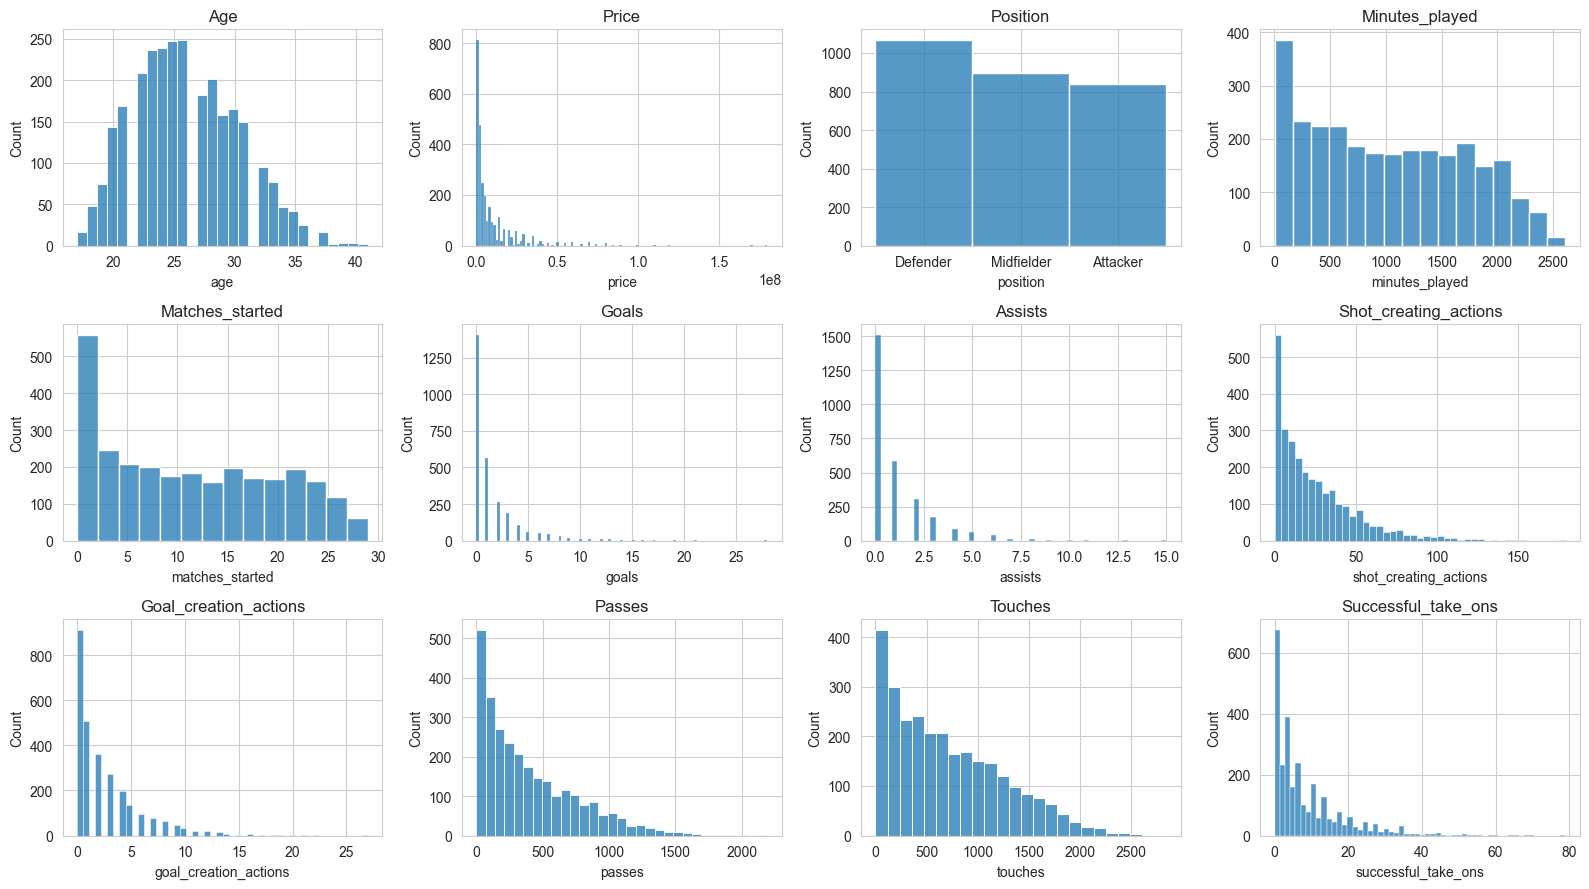

In [104]:
fig, axes = plt.subplots(3, 4, figsize=(16, 9))
axes = axes.ravel()

for i, feature in enumerate(['age', 'price', 'position', 'minutes_played', 'matches_started', 'goals', 'assists', 'shot_creating_actions', 'goal_creation_actions', 'passes', 'touches', 'successful_take_ons']):
    sns.histplot(data=df, x=feature, ax=axes[i], kde=False)
    axes[i].set_title(feature.capitalize())
    

fig.tight_layout()

plt.show()

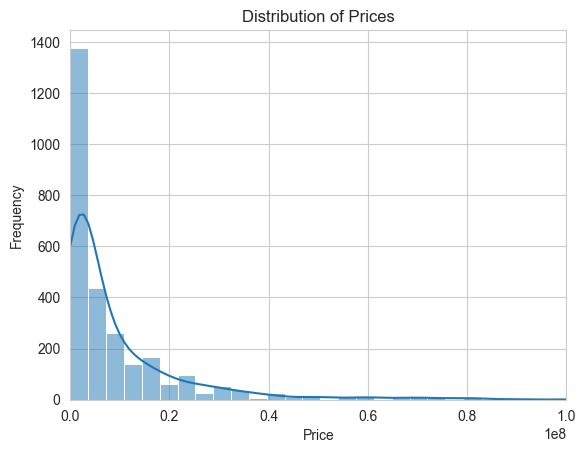

In [106]:
sns.histplot(data=df, x='price', bins=50, kde=True)
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.xlim(0, 100000000) 
plt.show()

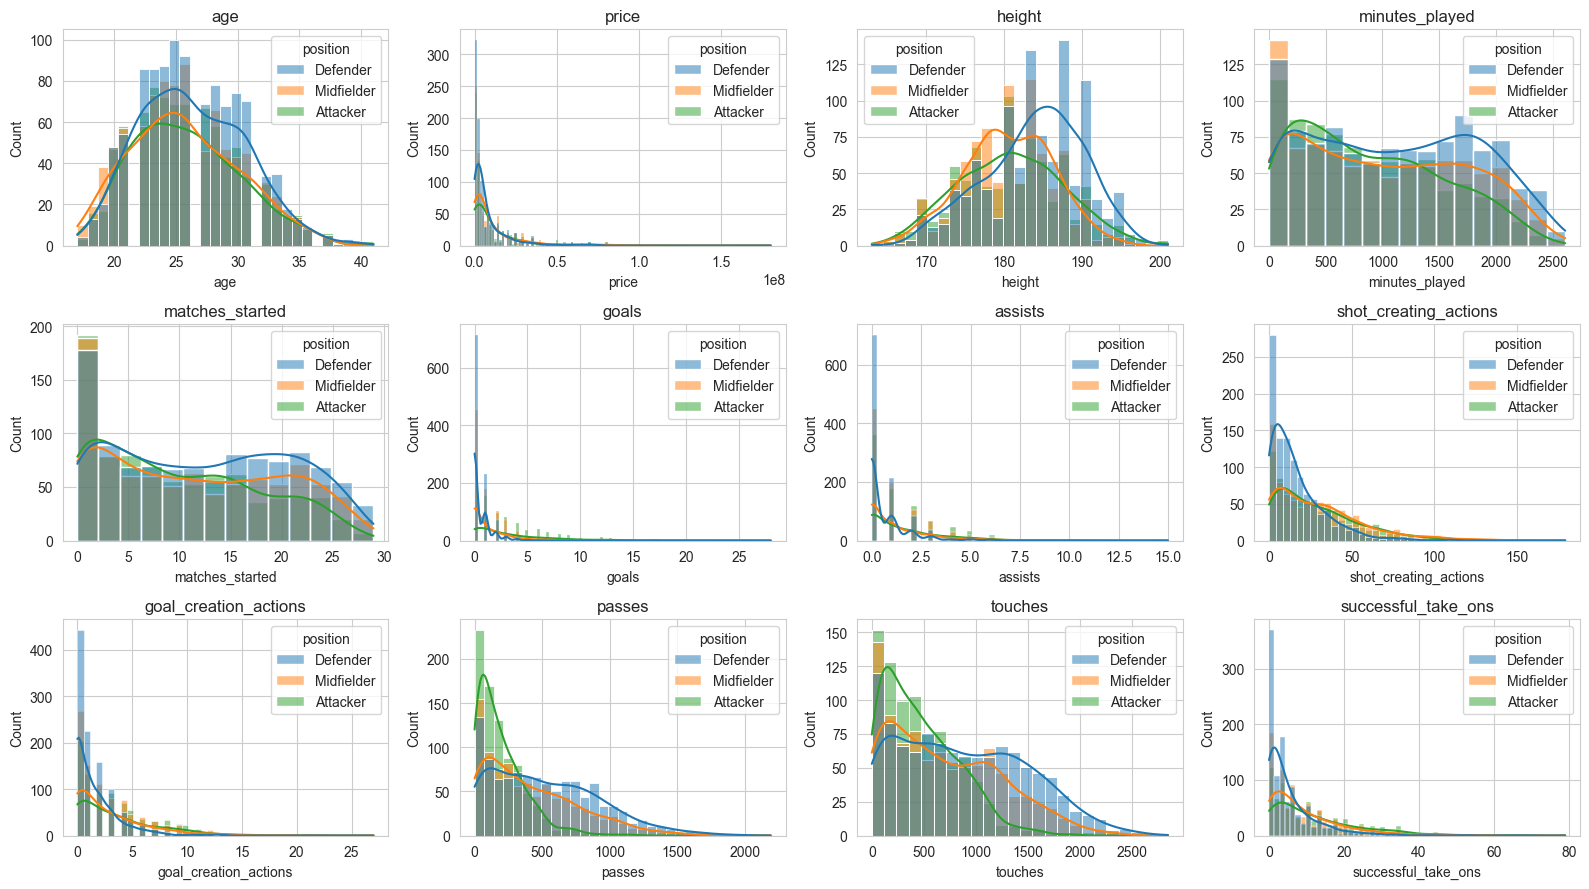

In [112]:
fig, axes = plt.subplots(3, 4, figsize=(16, 9))
axes = axes.ravel()

# Define the order of positions
position_order = ['Defender', 'Midfielder', 'Attacker']

# Iterate over each column and create a histogram sorted by player position
for i, column in enumerate(['age', 'price', 'height', 'minutes_played', 'matches_started', 'goals', 'assists', 'shot_creating_actions', 'goal_creation_actions', 'passes', 'touches', 'successful_take_ons']):
	sns.histplot(data=df, x=column, hue='position', hue_order=position_order, ax=axes[i], kde=True)
	axes[i].set_title(column)

# Adjust the layout of the subplots
fig.tight_layout()

# Show the plot
plt.show()


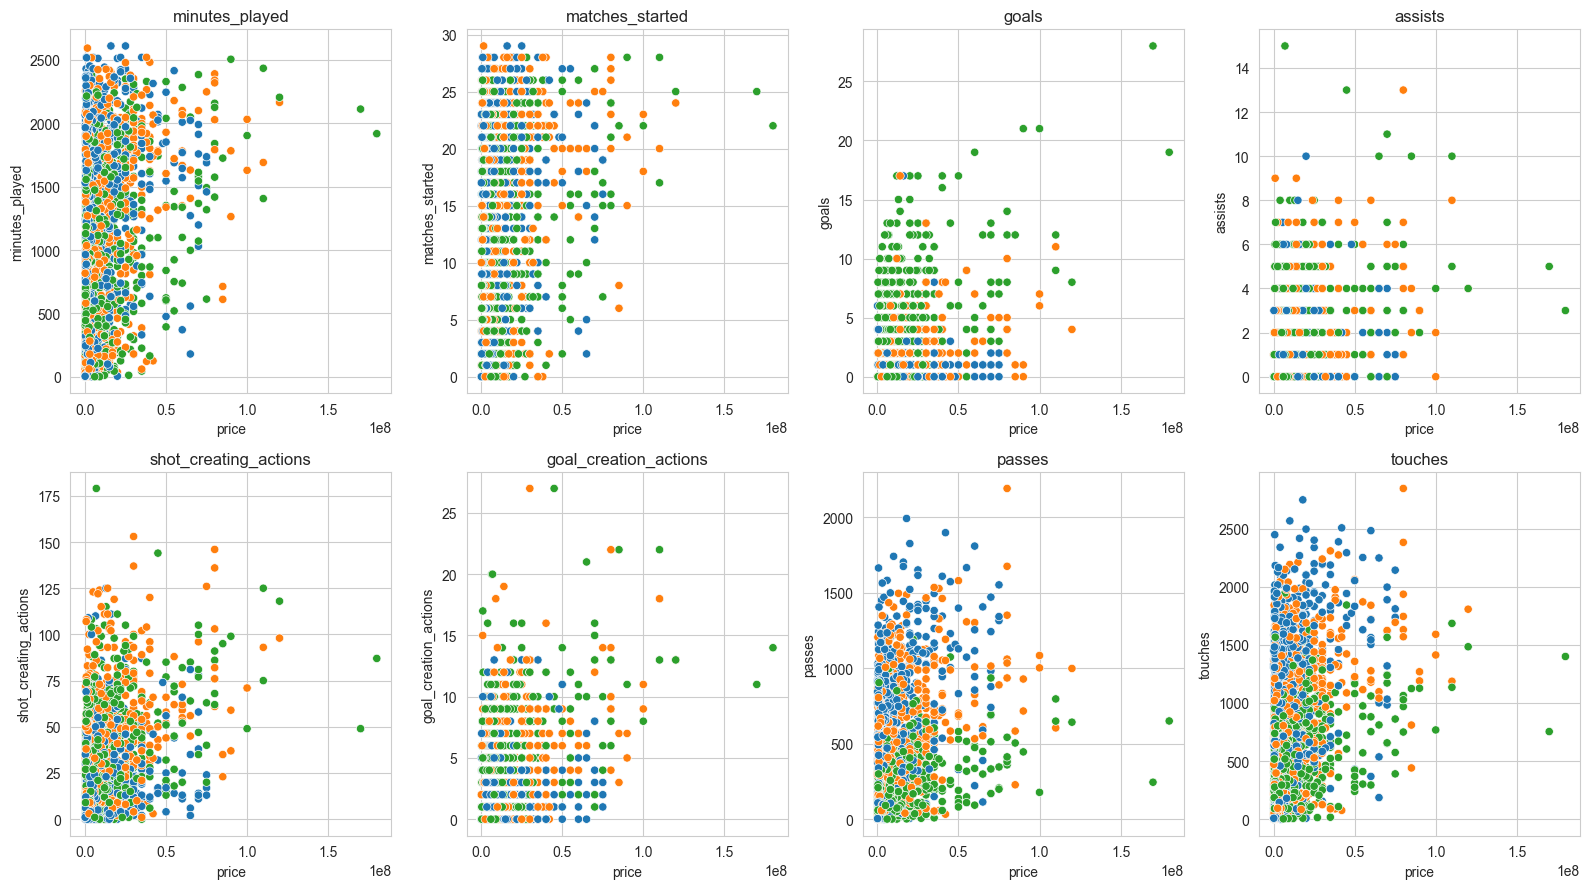

In [123]:
fig, axes = plt.subplots(2, 4, figsize=(16, 9))
axes = axes.ravel()

# Define the order of positions
position_order = ['Defender', 'Midfielder', 'Attacker']

for i, column in enumerate(['minutes_played', 'matches_started', 'goals', 'assists', 'shot_creating_actions', 'goal_creation_actions', 'passes', 'touches']):
    ax = sns.regplot(data=df, x='price', y=column, scatter_kws={'s': 10}, line_kws={}, ax=axes[i], ci=None, fit_reg=False)
    sns.scatterplot(data=df, x='price', y=column, hue='position', hue_order=position_order, ax=ax, legend=False)
    ax.set_title(column)

# Adjust the layout of the subplots
fig.tight_layout()

# Show the plot
plt.show()


From initial domain knowledge, we predict that the key, correlated columns will be a player's:

- age
- price
- position 
- minutes played 
- matches_started
- goals 
- assists
- shot_creating_actions
- goal_creation_actions
- passes
- touches

We will focus our initial analysis on these variables and expand our selection.

In [48]:
features_of_interest = [
    'age',
    'price',
    'position',
    'minutes_played',
    'matches_started',
    'goals',
    'assists',
    'shot_creating_actions',
    'goal_creation_actions',
    'passes',
    'touches',
]


In [49]:
df[features_of_interest].describe()

,age,price,minutes_played,matches_started,goals,assists,shot_creating_actions,goal_creation_actions,passes,touches
count,2800.000000,2.800000e+03,2800.000000,2800.000000,2800.000000,2800.000000,2797.000000,2797.000000,2797.000000,2797.000000
mean,25.948214,9.651884e+06,1012.769643,11.332857,1.511786,1.033571,24.597426,2.547372,393.254916,702.207365
std,4.343647,1.519840e+07,697.801611,8.331035,2.608531,1.607508,24.070286,3.215828,357.974177,551.631279
min,17.000000,2.500000e+04,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,1.400000e+06,386.000000,4.000000,0.000000,0.000000,6.000000,0.000000,105.000000,230.000000
50%,26.000000,4.000000e+06,959.500000,11.000000,0.000000,0.000000,17.000000,1.000000,288.000000,594.000000
75%,29.000000,1.200000e+07,1605.500000,19.000000,2.000000,2.000000,36.000000,4.000000,608.000000,1079.000000
max,41.000000,1.800000e+08,2610.000000,29.000000,28.000000,15.000000,179.000000,27.000000,2192.000000,2846.000000


### Observations
    
- The average age of a player in the top 7 European leagues is 25.9. This shows the inclination of clubs to promote youth players given that the common retirement age is about 35 years of old. 
- The average price of the players in our dataset is 9.6 million Euro's! This is a surprising figure given the total outlay of transfer fees that clubs normally spend. It is also important to note that the standard deviation of our class label is about 15 million Euro's, which is substantial. 
- Both goals and assists include 0 across their first and second quartile. We can conclude that the majority of players in our dataset have not scored or assisted this season.
- The average minutes played for all the players in the dataset is 1012 minutes - an insufficient amount of time to drive many statistics to a high-range.

In [50]:
features_of_interest.pop(features_of_interest.index('position'))

'position'

### Distribution of Features of Interest

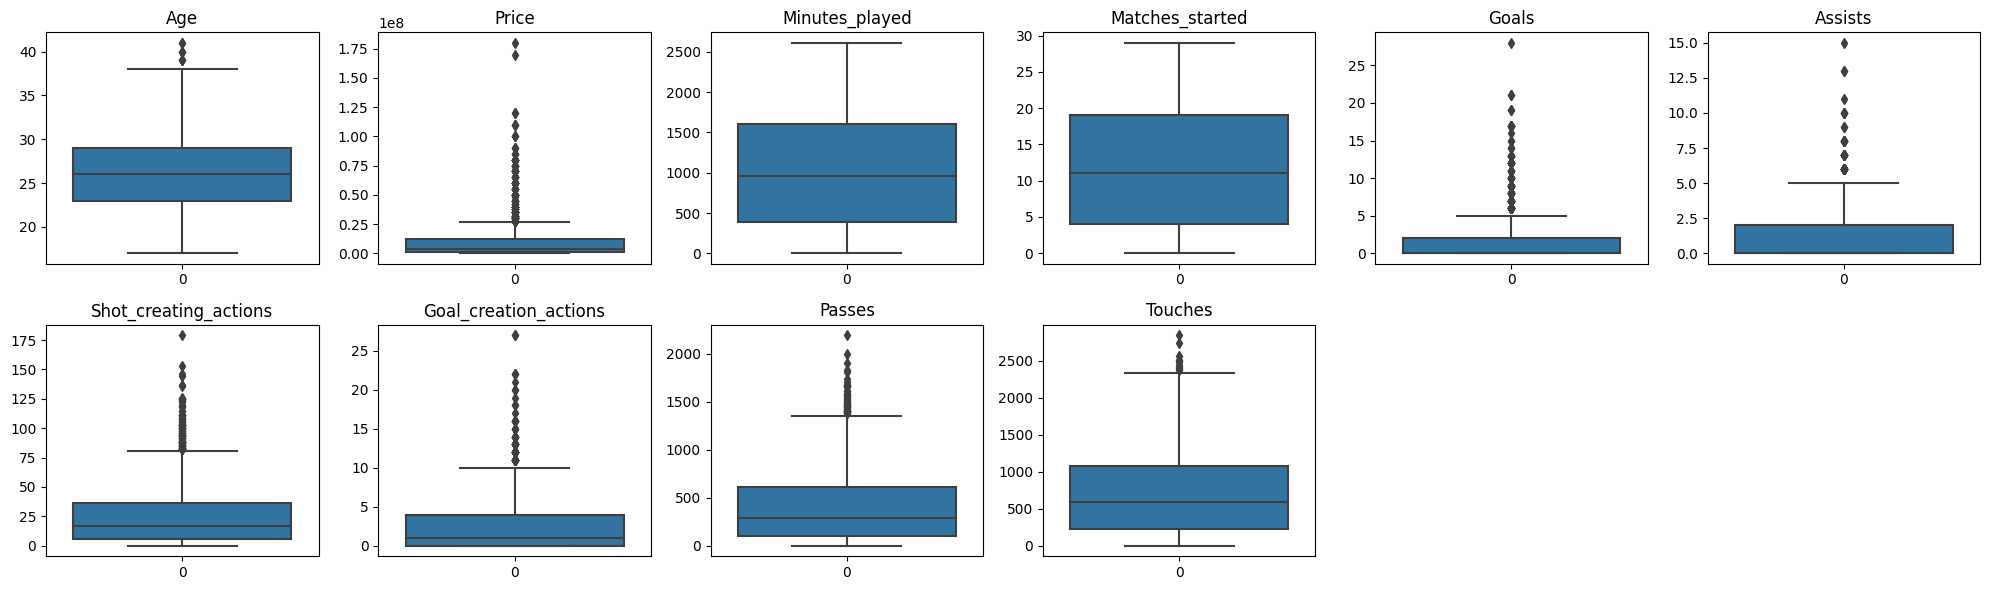

In [51]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(20, 6))

axes = axes.flatten()

for i, feature in enumerate(features_of_interest):

    if len(df[feature].unique()) > 1:
        
        sns.boxplot(ax=axes[i], data=df[feature], orient='v')
        axes[i].set_title(feature.capitalize())
        
for j in range(len(features_of_interest), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

### Observations

- Price contains a lot of outliers in the dataset. These are the superstar players, who's price could be inflated through other factors such as marketing prowess, nationality, or the club that they belong to. (some smaller clubs value important players higher to retain their services)
- Goals and assists also contain many outliers with a handful of players exceeding the IQR range. 
- The same observation follows for the shot and goal creating actions - there are many above-average players that are generating more than the average player in the dataset.
- The minutes and matches played follow an even distribution which is expected as there are about 22 calendar games played thus far for this dataset.
- The removal of outliers may benefit the model, especially within the *price* feature.

### Scatter Plot Correlations with the Class Variable

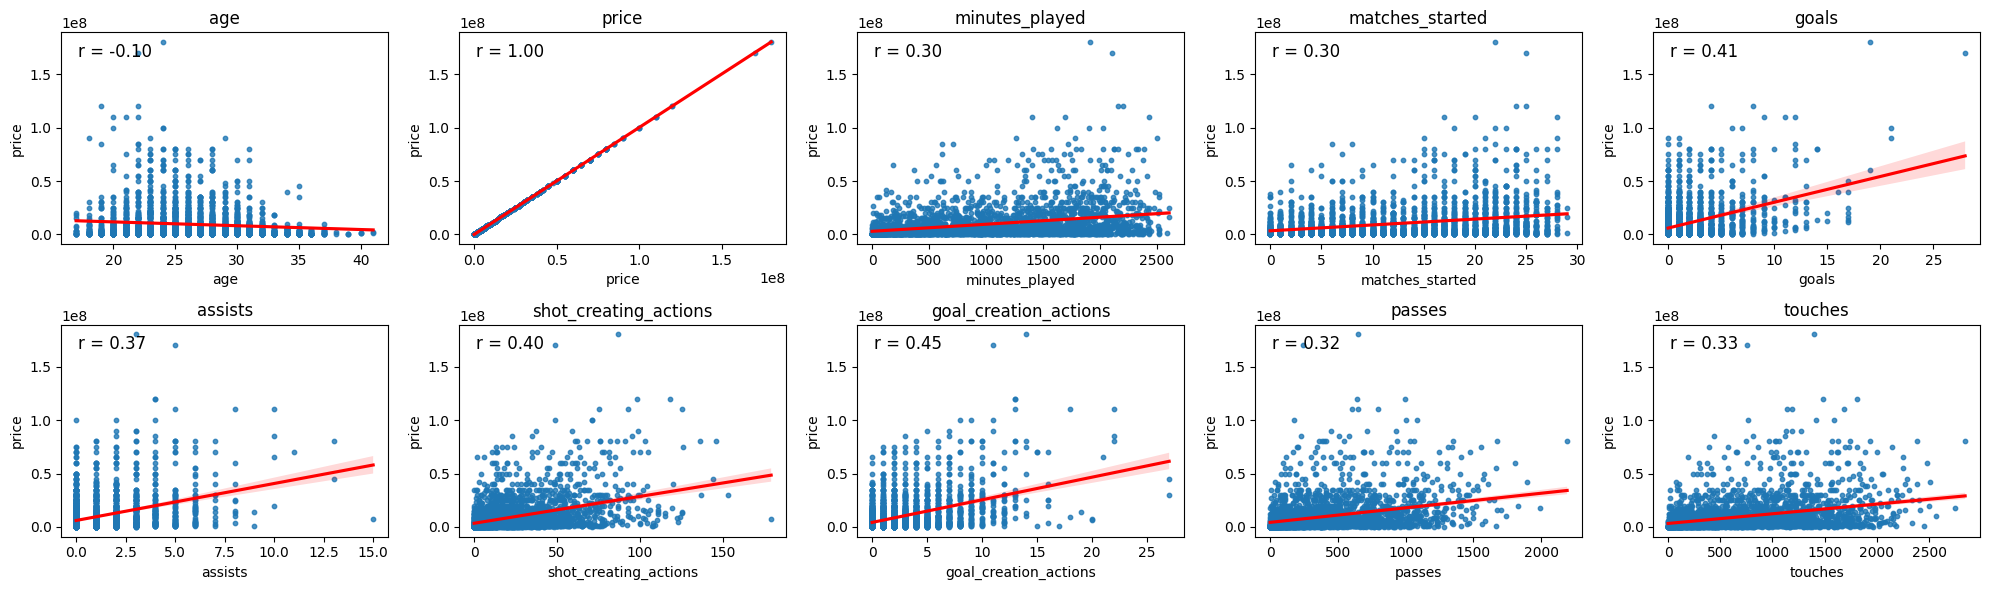

In [54]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 6))

axes = axes.flatten()
for i, feature in enumerate(features_of_interest):

    sns.regplot(ax=axes[i], x=feature, y='price', data=df, scatter_kws={'s':10}, line_kws={'color':'red'})
    axes[i].set_title(feature)
    
    corr_coef = df[feature].corr(df['price'])
    axes[i].text(0.05, 0.95, f'r = {corr_coef:.2f}', transform=axes[i].transAxes, ha='left', va='top', fontsize=12)
    
fig.tight_layout()
plt.show()


### Observations

- It is interesting to note that age may be completely independent of a player's value as per the weak r-score of -0.10. This indicates that a player's value decreases slightly with age. A possible explanation for this may be that a club may value experience over youth development, therefore valuing an experienced player more highly. In additon, it could be that a younger player has potential to grow increasing their value, but an experienced player is more established within the game, creating a conflict between the determination of value.
- Goals, shot & goal creating actions showed a weak, positive correlation with player value with scores greater than 0.4. 
- Overall, there isn't a specific feature that shows a strong, positive or negative correlation with the class variable, which may impact the accuracy of the regression model. 

### Heatmap of Variable Correlations

<AxesSubplot:>

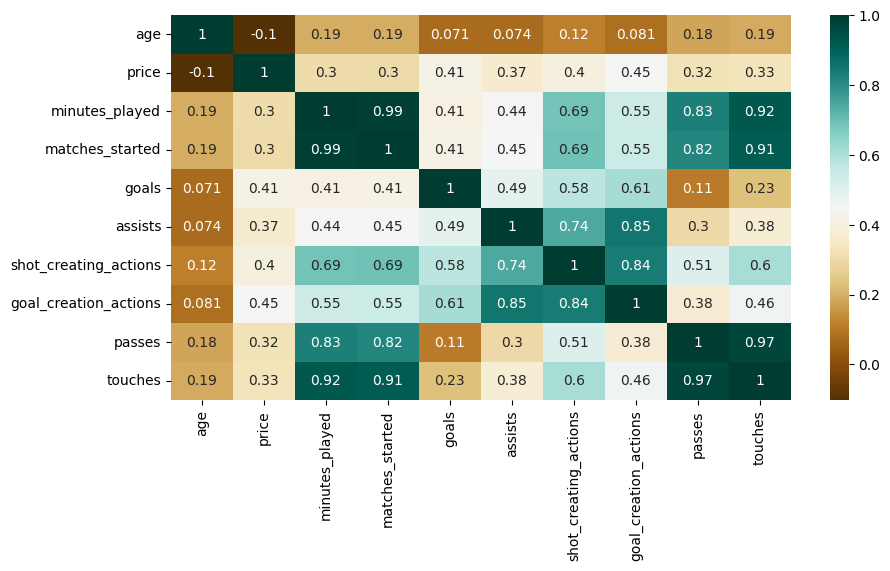

In [55]:
plt.figure(figsize=(10,5))
c= df[features_of_interest].corr()
sns.heatmap(c,cmap="BrBG",annot=True)

In [56]:
# TODO: Add more visuals, add visuals for features outside features of interest

## Player Play Style - A Clustering Algorithm <a class="anchor" id="clustering"></a>

#### Objective

As per our project report, the objective of the clustering algorithm is to label players in accordance to their playing style based on their playing statistics. That being said, we will be primarily be using in-game statistics to compute this algorithm.

In [124]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import sklearn
from sklearn.cluster import KMeans
import sklearn.metrics as sm
from sklearn import datasets
from sklearn.metrics import confusion_matrix, classification_report

In [183]:
player_performance_stats = df.columns[9:23]
player_stats_df = df[player_performance_stats]

In [184]:
player_stats_df.count()

minutes_played             2797
matches_played             2797
matches_started            2797
tackles_won                2797
shot_creating_actions      2797
goal_creation_actions      2797
fouls                      2797
aerial_duels_won           2797
assists                    2797
progressive_passes         2797
successful_take_ons        2797
total_carrying_distance    2797
goals                      2797
total_shots                2797
dtype: int64

In [185]:
player_stats_df = player_stats_df[~player_stats_df['shot_creating_actions'].isna()].reset_index(drop=True)

In [186]:
from sklearn.preprocessing import scale

scaled_data = scale(player_stats_df)
variable_names = player_stats_df.columns

X = pd.DataFrame(scaled_data, columns=variable_names)

In [187]:
X.columns

Index(['minutes_played', 'matches_played', 'matches_started', 'tackles_won',
       'shot_creating_actions', 'goal_creation_actions', 'fouls',
       'aerial_duels_won', 'assists', 'progressive_passes',
       'successful_take_ons', 'total_carrying_distance', 'goals',
       'total_shots'],
      dtype='object')

In [188]:
clustering  = KMeans(n_clusters=3,random_state=5)


clustering.fit(X)
clustering.labels_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([2, 2, 1, ..., 0, 1, 1], dtype=int32)

#### Comparing Polar Statistics 

To visually evaluate the clustering labels, we evaluate a scatter plot

In [197]:
cluster_labels = pd.Series(clustering.labels_, name='cluster_label')
result_df = pd.concat([X, cluster_labels], axis=1)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

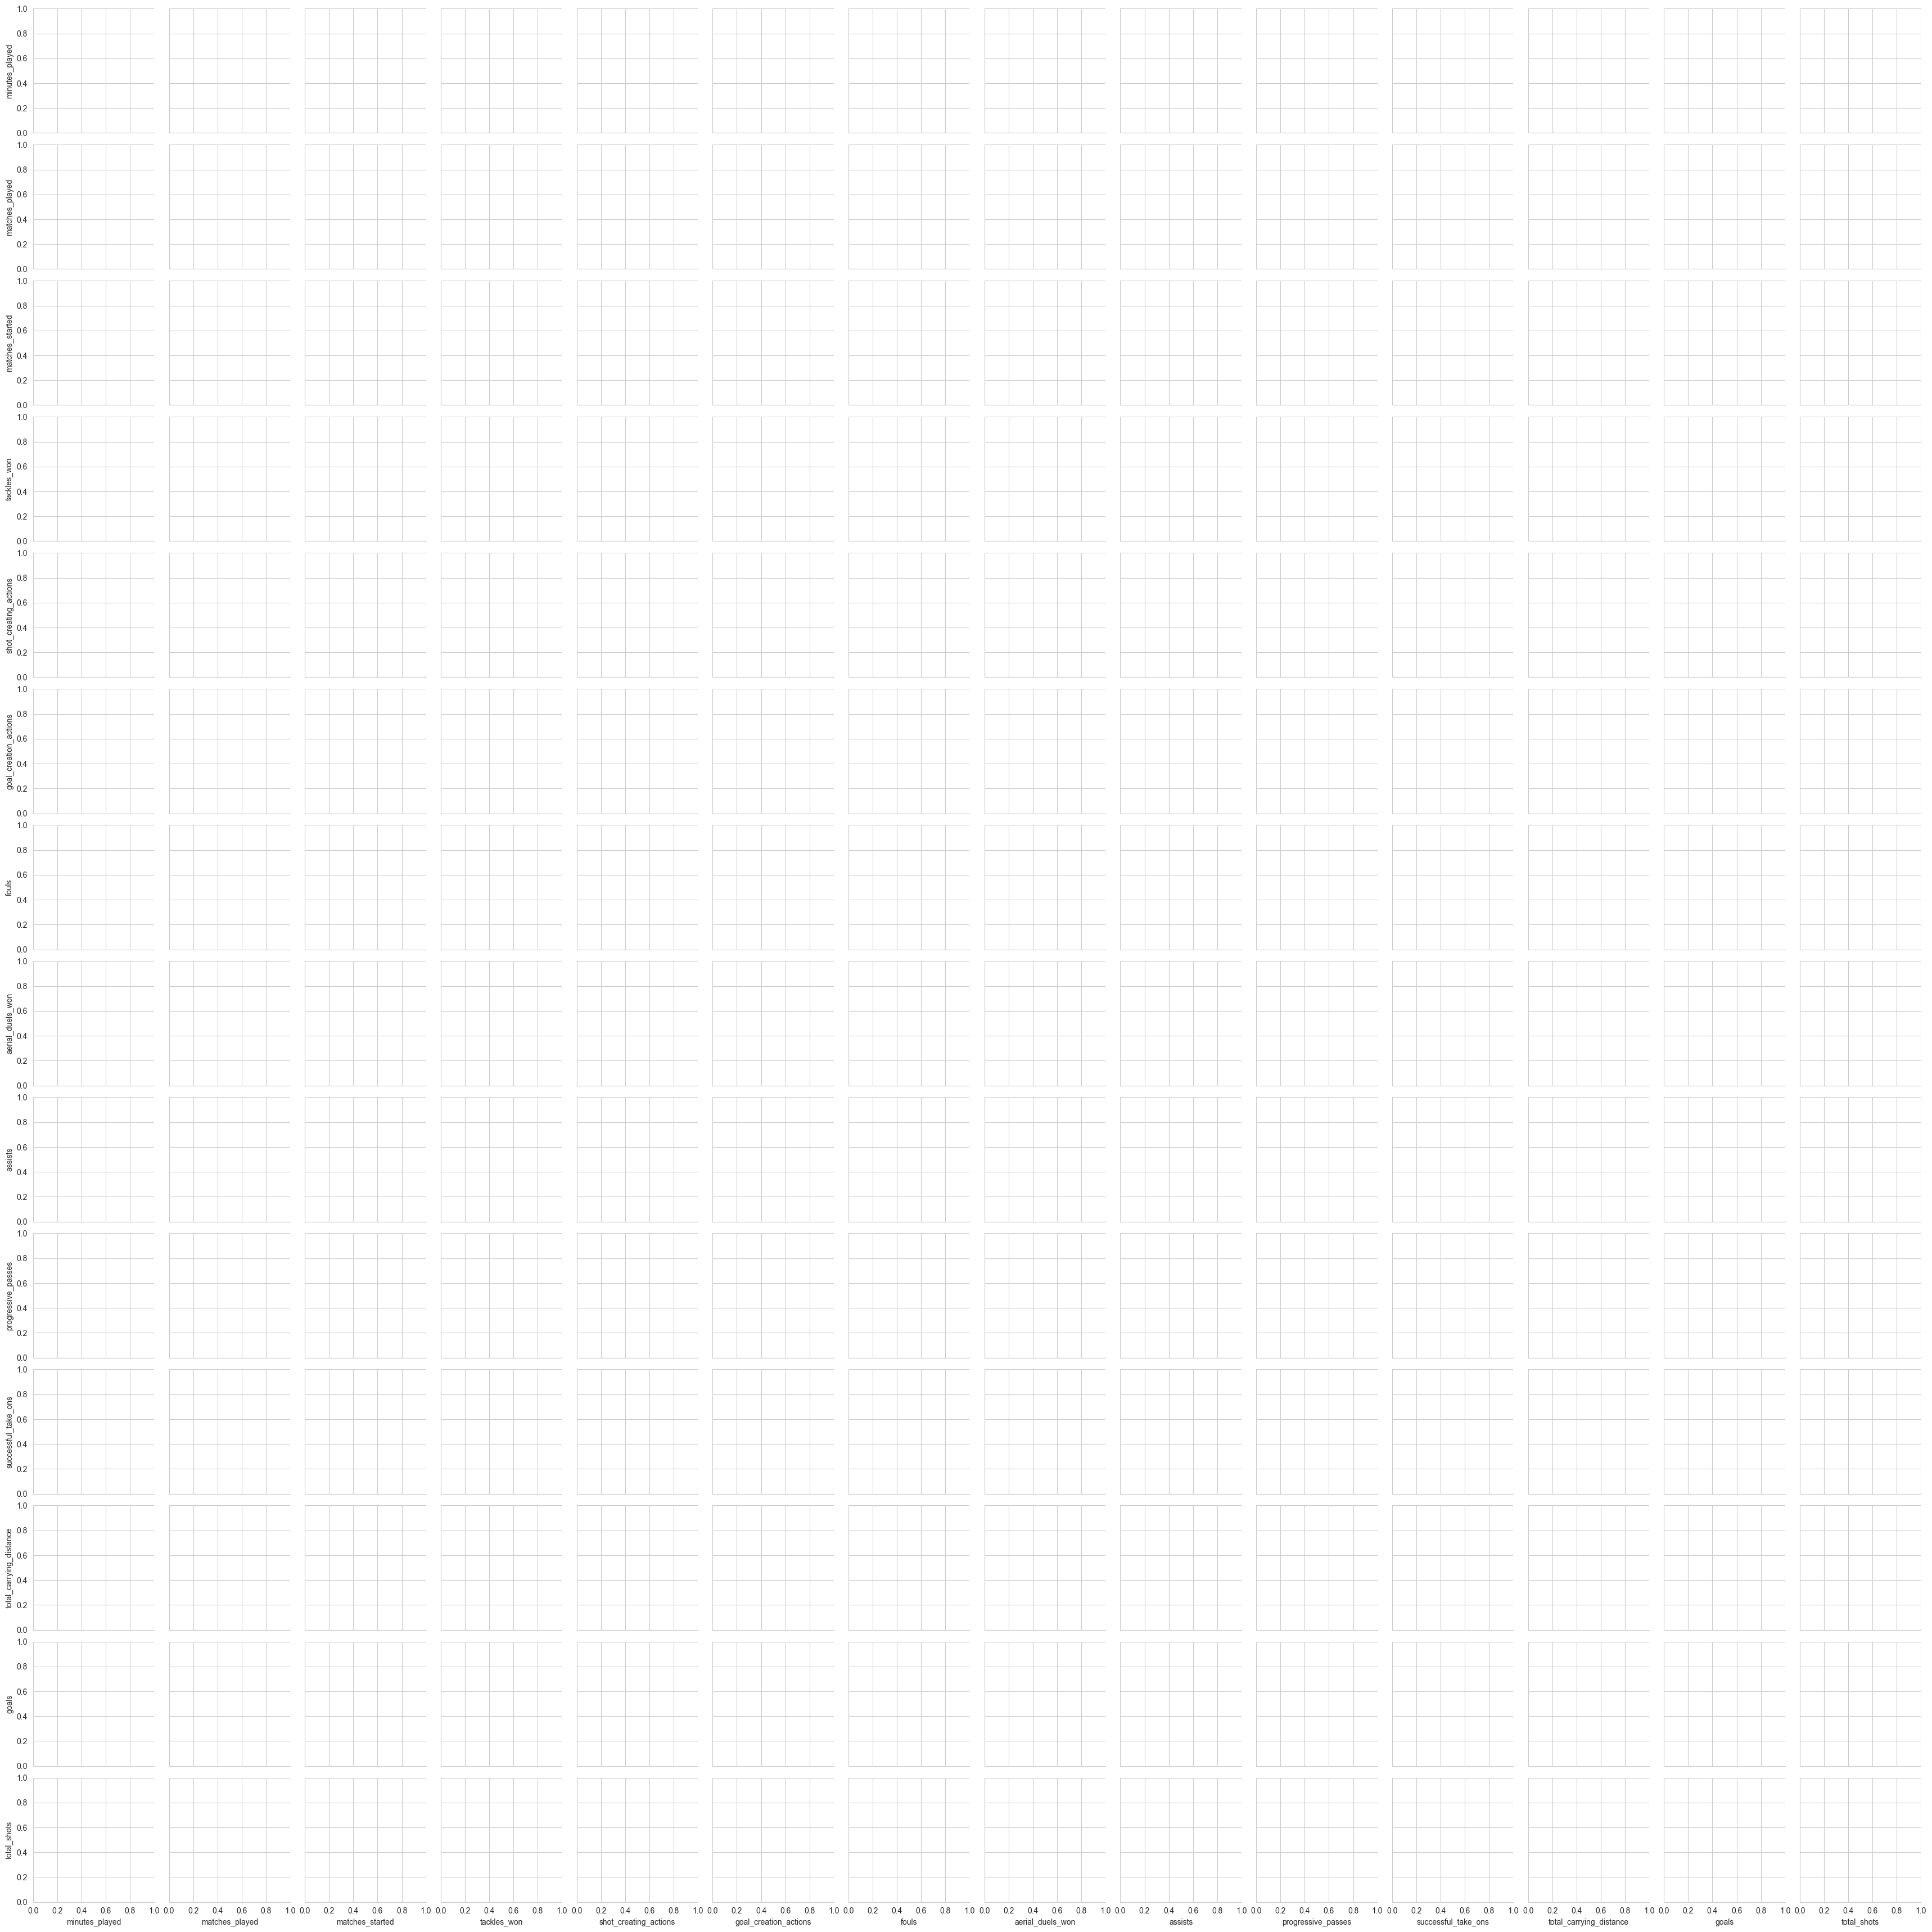

In [198]:
color_theme = np.array(['#008fd5','#fc4f30','#009966'])
sns.pairplot(result_df, hue="cluster_label", palette=color_theme)

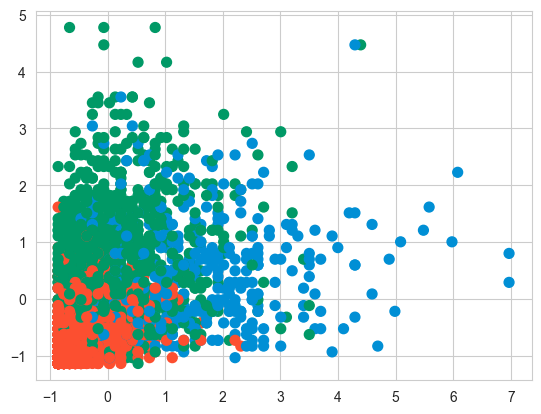

In [189]:
color_theme = np.array(['#008fd5','#fc4f30','#009966'])
plt.scatter(x=X['successful_take_ons'],
            y=X['tackles_won'],
            c=color_theme[clustering.labels_],
            s=50)

plt.show()

In [126]:
df.columns

Index(['name', 'price', 'position', 'age', 'nationality', 'height', 'foot',
       'join_date', 'contract_expiration', 'minutes_played', 'matches_played',
       'matches_started', 'tackles_won', 'shot_creating_actions',
       'goal_creation_actions', 'fouls', 'aerial_duels_won', 'assists',
       'progressive_passes', 'successful_take_ons', 'total_carrying_distance',
       'goals', 'total_shots', 'Attacker', 'Defender', 'Midfielder', 'both',
       'left', 'right', 'passes', 'defensive_actions', 'touches', 'cards'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import scale

scaled_data = scale(iris.data)

# save feature names
variable_names = iris.feature_names

# save feature data into a dataframe
X = pd.DataFrame(scaled_data, columns=variable_names)

# load the target into a dataframe
y = pd.DataFrame(iris.target)

# name the column of the target
y.columns = ['Target']

# show the first 5 rows of data
X.head()

## Predicting Player Play Style by Linear Regression <a class="anchor" id="linear-regression"></a>

### First Iteration - Initial Dataset

We will start building the optimal linear regression model with our features of interest and continually increment the number of features as needed.

In [57]:
features = [
    'age', 
    'minutes_played',
    'matches_played',
    'matches_started',
    'shot_creating_actions',
    'goal_creation_actions',
    'assists',
    'progressive_passes',
    'total_carrying_distance',
    'goals',
    'total_shots',
    'passes', 
    'touches',
    'Attacker',
    'Defender', 
    'Midfielder',
    'both',
    'left', 
    'right'
]

#### Dropping Nulls

We will perform the dropping of nulls for every iteration of the model we build as to focus on the features that require the dropping of nulls. In our case, we will have to drop the null values from the features selected. Replacing null values with the mean or median of the feature is not appropriate in this case because it will affect that observation's correlation with player value.

In [58]:
df.dropna(subset=['shot_creating_actions'], inplace=True)

# shot_creating_actions' null values also aligned with the other columns' null values.

In [59]:
X = df[features]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [60]:
X_train.shape

(2237, 19)

In [61]:
lreg = LinearRegression()
lreg.fit(X_train, y_train)

LinearRegression()

#### Coefficients

In [62]:
coefficients = pd.DataFrame(lreg.coef_, features, columns = ['Coeff']).sort_values(by='Coeff', ascending=False)
coefficients

,Coeff
right,7.137763e+06
left,6.239039e+06
both,4.030704e+06
goals,1.904904e+06
goal_creation_actions,1.270701e+06
Midfielder,1.106498e+06
total_shots,2.112760e+05
passes,4.386833e+04
shot_creating_actions,2.967554e+04
total_carrying_distance,4.569787e+02


In [63]:
predictions = lreg.predict(X_test)

#### Actual v.s. Predicted Player Value

Text(0, 0.5, 'Predicted Player Value')

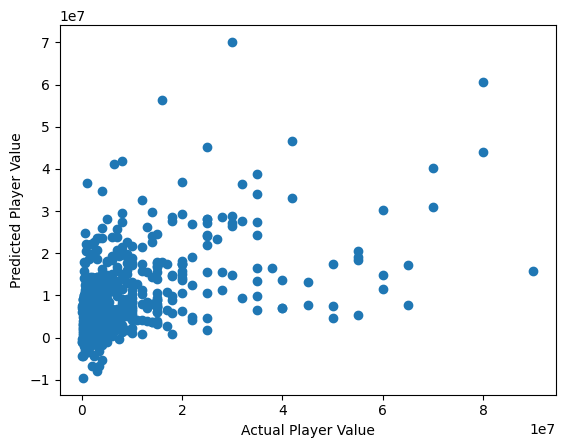

In [64]:
plt.scatter(y_test, predictions)
plt.xlabel('Actual Player Value')
plt.ylabel('Predicted Player Value')

#### Visualizing the Residuals

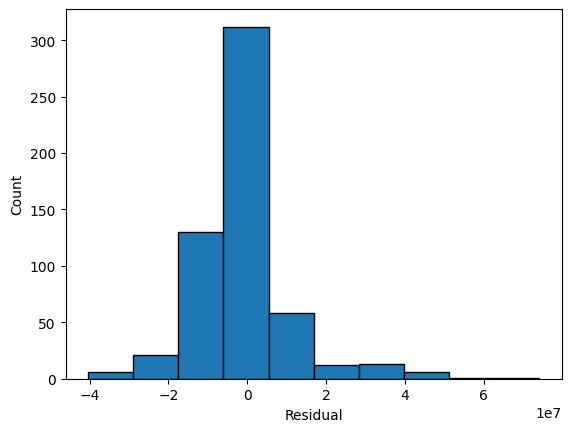

In [65]:
plt.hist(y_test - predictions, edgecolor='black')
plt.ylabel("Count")
plt.xlabel("Residual")
plt.show()

#### Mean Absolute Error

In [66]:
metrics.mean_absolute_error(y_test, predictions)

7659104.110326274

#### Mean Squared Error

In [67]:
metrics.mean_squared_error(y_test, predictions)

140992283508909.72

#### Root-Mean Square

In [68]:
np.sqrt(metrics.mean_squared_error(y_test, predictions))

11874017.159702512

Our first step in working towards better accuracy and performance is to remove the outliers in the core features. By doing so, we will improve lineality in the model and remove the influence of extreme values in the regression model.

### Second Iteration - Removal of Outliers

We will leverage each feature's interquartile range to determine non-extreme values for each feature. 

In [69]:
features = [
    'age', 
    'minutes_played',
    'matches_played',
    'matches_started',
    'shot_creating_actions',
    'goal_creation_actions',
    'assists',
    'progressive_passes',
    'total_carrying_distance',
    'goals',
    'total_shots',
    'passes', 
    'touches',
    'Attacker',
    'Defender', 
    'Midfielder',
    'both',
    'left', 
    'right'
]

In [70]:
indices_to_drop = []

# Loop over each feature and find outliers using the IQR method
for feature in features:
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    # Find the indexes where the values are below or above the lower and upper bounds respectively.
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)].index
    # Add the indices to the indices_to_drop.
    indices_to_drop.extend(outliers)

# Drop duplicate indices and sort the list
indices_to_drop = list(set(indices_to_drop))
indices_to_drop.sort()

# Remove the rows containing outliers
df = df.drop(indices_to_drop).reset_index(drop=True)

# Print the number of rows dropped
print(f"Total rows dropped: {len(indices_to_drop)}")

Total rows dropped: 496


In [71]:
X = df[features]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [72]:
lreg = LinearRegression()
lreg.fit(X_train, y_train)

LinearRegression()

In [73]:
coefficients = pd.DataFrame(lreg.coef_, features, columns = ['Coeff']).sort_values(by='Coeff', ascending=False)
coefficients

,Coeff
right,7.005488e+06
left,6.305457e+06
Attacker,9.830601e+05
assists,8.339585e+05
goal_creation_actions,7.629170e+05
goals,5.932785e+05
Midfielder,3.580973e+05
total_shots,2.577447e+05
matches_started,9.181162e+04
passes,4.743285e+04


In [74]:
predictions = lreg.predict(X_test)

#### Actual v.s. Predicted Player Value

Text(0, 0.5, 'Predicted Player Value')

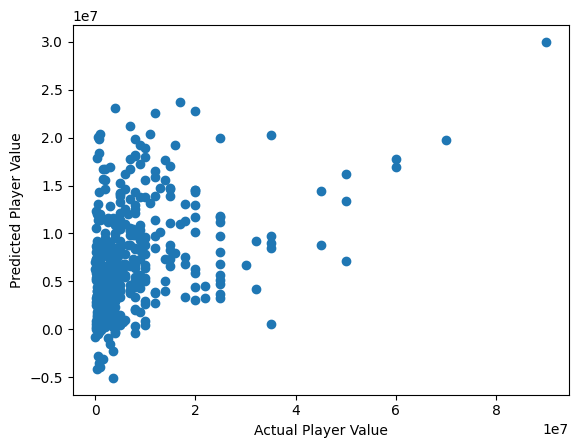

In [75]:
plt.scatter(y_test, predictions)
plt.xlabel('Actual Player Value')
plt.ylabel('Predicted Player Value')

#### Visualizing the Residuals

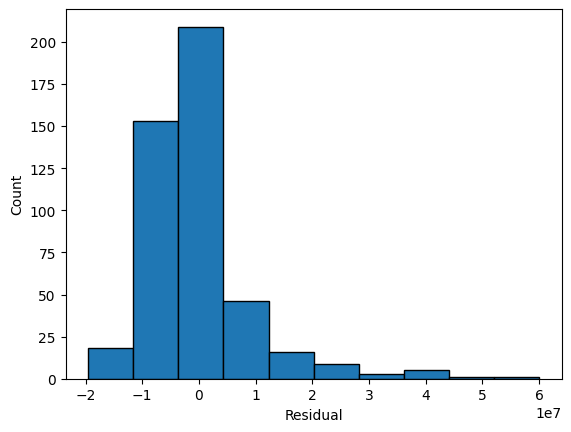

In [76]:
plt.hist(y_test - predictions, edgecolor='black')
plt.ylabel("Count")
plt.xlabel("Residual")
plt.show()

#### Mean Absolute Error

In [77]:
metrics.mean_absolute_error(y_test, predictions)

6113963.070555429

#### Mean Squared Error

In [78]:
metrics.mean_squared_error(y_test, predictions)

89341122728980.95

#### Root-Mean Square

In [79]:
np.sqrt(metrics.mean_squared_error(y_test, predictions))

9452043.309728377

### Third Iteration - Regression by Position

For this iteration, we will apply a linear regression to each distinct player position (attacker, midfielder, defender) to determine any changes to the ordering of the coefficients and performance of the model. We will also tailor the features to include each position's common traits and actions.

In [80]:
attackers = df[df['Attacker'] == 1]
midfielders = df[df['Midfielder'] == 1]
defenders = df[df['Defender'] == 1]

In [81]:
attacker_features = [
    'age', 
    'minutes_played',
    'matches_played',
    'matches_started',
    'shot_creating_actions',
    'goal_creation_actions',
    'assists',
    'progressive_passes',
    'total_carrying_distance',
    'goals',
    'total_shots',
    'passes', 
    'touches',
]

midfielder_features = [
    'age', 
    'minutes_played',
    'matches_played',
    'matches_started',
    'progressive_passes',
    'shot_creating_actions',
    'goal_creation_actions',
    'total_carrying_distance',
    'goals',
    'passes', 
    'touches',
    'both',
    'left', 
    'right',
    'fouls',
    'tackles_won',
    'defensive_actions',
]

defender_features = [
    'age', 
    'minutes_played',
    'matches_played',
    'matches_started',
    'progressive_passes',
    'total_carrying_distance',
    'goals',
    'passes', 
    'touches',
    'both',
    'left', 
    'right',
    'fouls',
    'tackles_won',
    'defensive_actions',
]

In [82]:
X = attackers[attacker_features]
y = attackers['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
lreg = LinearRegression()
lreg.fit(X_train, y_train)
attacker_coefficients = pd.DataFrame(lreg.coef_, attacker_features, columns = ['Coeff']).sort_values(by='Coeff', ascending=False)
attacker_predictions = lreg.predict(X_test)

Text(0, 0.5, 'Predicted Player Value')

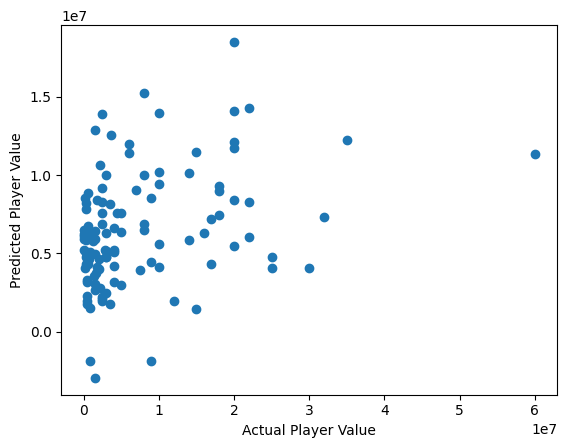

In [83]:
plt.scatter(y_test, attacker_predictions)
plt.xlabel('Actual Player Value')
plt.ylabel('Predicted Player Value')

#### Visualizing the Residuals

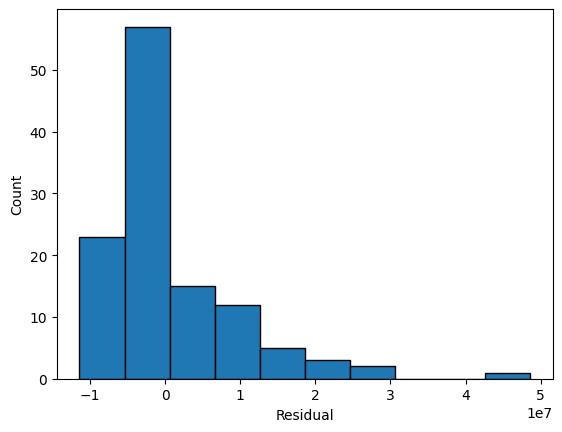

In [84]:
plt.hist(y_test - attacker_predictions, edgecolor='black')
plt.ylabel("Count")
plt.xlabel("Residual")
plt.show()

#### Mean Absolute Error

In [85]:
metrics.mean_absolute_error(y_test, attacker_predictions)

6012912.28059775

#### Mean Squared Error

In [87]:
metrics.mean_squared_error(y_test, attacker_predictions)

76724556854556.86

#### Root-Mean Square

In [88]:
np.sqrt(metrics.mean_squared_error(y_test, attacker_predictions))

8759255.496590842

In [89]:
X = midfielders[midfielder_features]
y = midfielders['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
lreg = LinearRegression()
lreg.fit(X_train, y_train)
midfield_coefficients = pd.DataFrame(lreg.coef_, midfielder_features, columns = ['Coeff']).sort_values(by='Coeff', ascending=False)
midfield_predictions = lreg.predict(X_test)

Text(0, 0.5, 'Predicted Player Value')

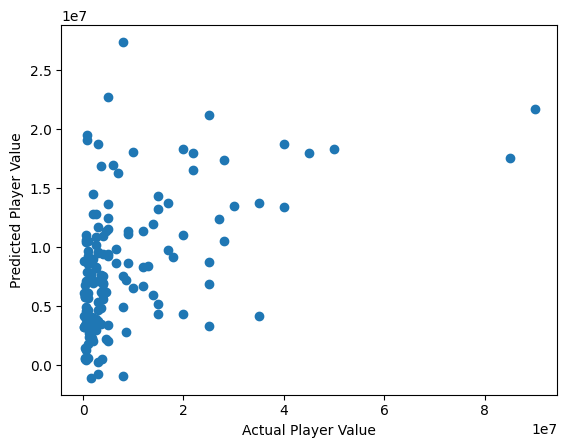

In [90]:
plt.scatter(y_test, midfield_predictions)
plt.xlabel('Actual Player Value')
plt.ylabel('Predicted Player Value')

#### Visualizing the Residuals

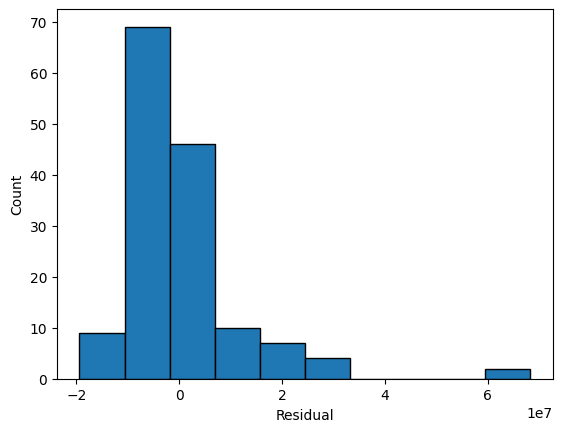

In [91]:
plt.hist(y_test - midfield_predictions, edgecolor='black')
plt.ylabel("Count")
plt.xlabel("Residual")
plt.show()

#### Mean Absolute Error

In [93]:
metrics.mean_absolute_error(y_test, midfield_predictions)

7450062.112795197

#### Mean Squared Error

In [94]:
metrics.mean_squared_error(y_test, midfield_predictions)

144403878111358.78

#### Root-Mean Square

In [95]:
np.sqrt(metrics.mean_squared_error(y_test, midfield_predictions))

12016816.471568448

In [96]:
X = defenders[defender_features]
y = defenders['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
lreg = LinearRegression()
lreg.fit(X_train, y_train)
defender_coefficients = pd.DataFrame(lreg.coef_, defender_features, columns = ['Coeff']).sort_values(by='Coeff', ascending=False)
defender_predictions = lreg.predict(X_test)

Text(0, 0.5, 'Predicted Player Value')

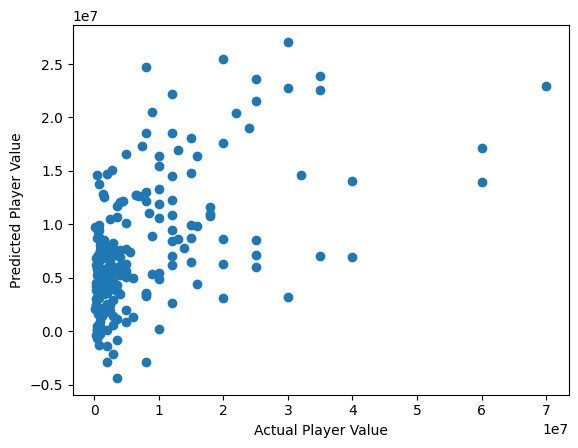

In [97]:
plt.scatter(y_test, defender_predictions)
plt.xlabel('Actual Player Value')
plt.ylabel('Predicted Player Value')

#### Visualizing the Residuals

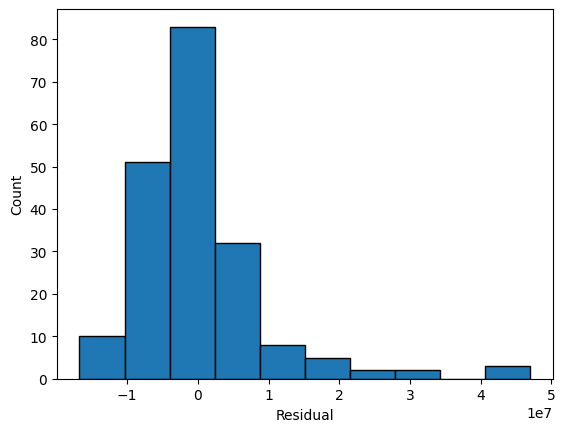

In [98]:
plt.hist(y_test - defender_predictions, edgecolor='black')
plt.ylabel("Count")
plt.xlabel("Residual")
plt.show()

#### Mean Absolute Error

In [99]:
metrics.mean_absolute_error(y_test, defender_predictions)

5997713.620713663

#### Mean Squared Error

In [100]:
metrics.mean_squared_error(y_test, defender_predictions)

86784179739924.38

#### Root-Mean Square

In [101]:
np.sqrt(metrics.mean_squared_error(y_test, defender_predictions))

9315802.688975565

In [102]:
### Fourth Iteration - Synthetic Data

In [104]:
df.columns

Index(['name', 'price', 'position', 'age', 'nationality', 'height', 'foot',
       'join_date', 'contract_expiration', 'minutes_played', 'matches_played',
       'matches_started', 'tackles_won', 'shot_creating_actions',
       'goal_creation_actions', 'fouls', 'aerial_duels_won', 'assists',
       'progressive_passes', 'successful_take_ons', 'total_carrying_distance',
       'goals', 'total_shots', 'Attacker', 'Defender', 'Midfielder', 'both',
       'left', 'right', 'passes', 'defensive_actions', 'touches', 'cards'],
      dtype='object')

In [116]:
X = df[['price', 'age', 'minutes_played', 'goals']]

In [117]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Find the optimal number of clusters using the silhouette score
scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    scores.append(score)

# Plot the silhouette scores for different number of clusters
import matplotlib.pyplot as plt

plt.plot(range(2, 11), scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()


In [119]:
# Train the clustering algorithm
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_scaled)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5, random_state=42)

In [121]:
# Get the cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Add the cluster labels to the original DataFrame
df['cluster'] = labels

# Analyze the centroids of each cluster
cluster_summary = df.groupby('cluster')[['price', 'age', 'minutes_played', 'goals']].mean()
print(cluster_summary)


                price        age  minutes_played     goals
cluster                                                   
0        3.691192e+06  30.471530      600.587189  0.341637
1        4.049660e+07  24.646259     1214.979592  1.102041
2        6.218201e+06  26.248394     1683.708779  0.447537
3        4.259321e+06  22.038615      354.242344  0.227696
4        7.482754e+06  26.042781     1269.165775  2.967914
